In [1]:
import h5py
import lightkurve
from astroNN.shared.matplotlib import pylab_style

pylab_style(paper=True)

f = h5py.File("APOKASC2_lightcurves.h5", "r")
# lc = np.array(f["1027337"])
# lc = lightkurve.LightCurve({"flux": lc[0], "time": lc[1]}).normalize(unit="ppm")

search = lightkurve.search_lightcurve(f"KIC 1027337")
lc = search.download_all().stitch().normalize(unit="ppm")

pg = lc.to_periodogram(normalization="psd", minimum_frequency=1, maximum_frequency=300)
# ax = pg.plot()
snr = pg.flatten()
seis = snr.to_seismology()

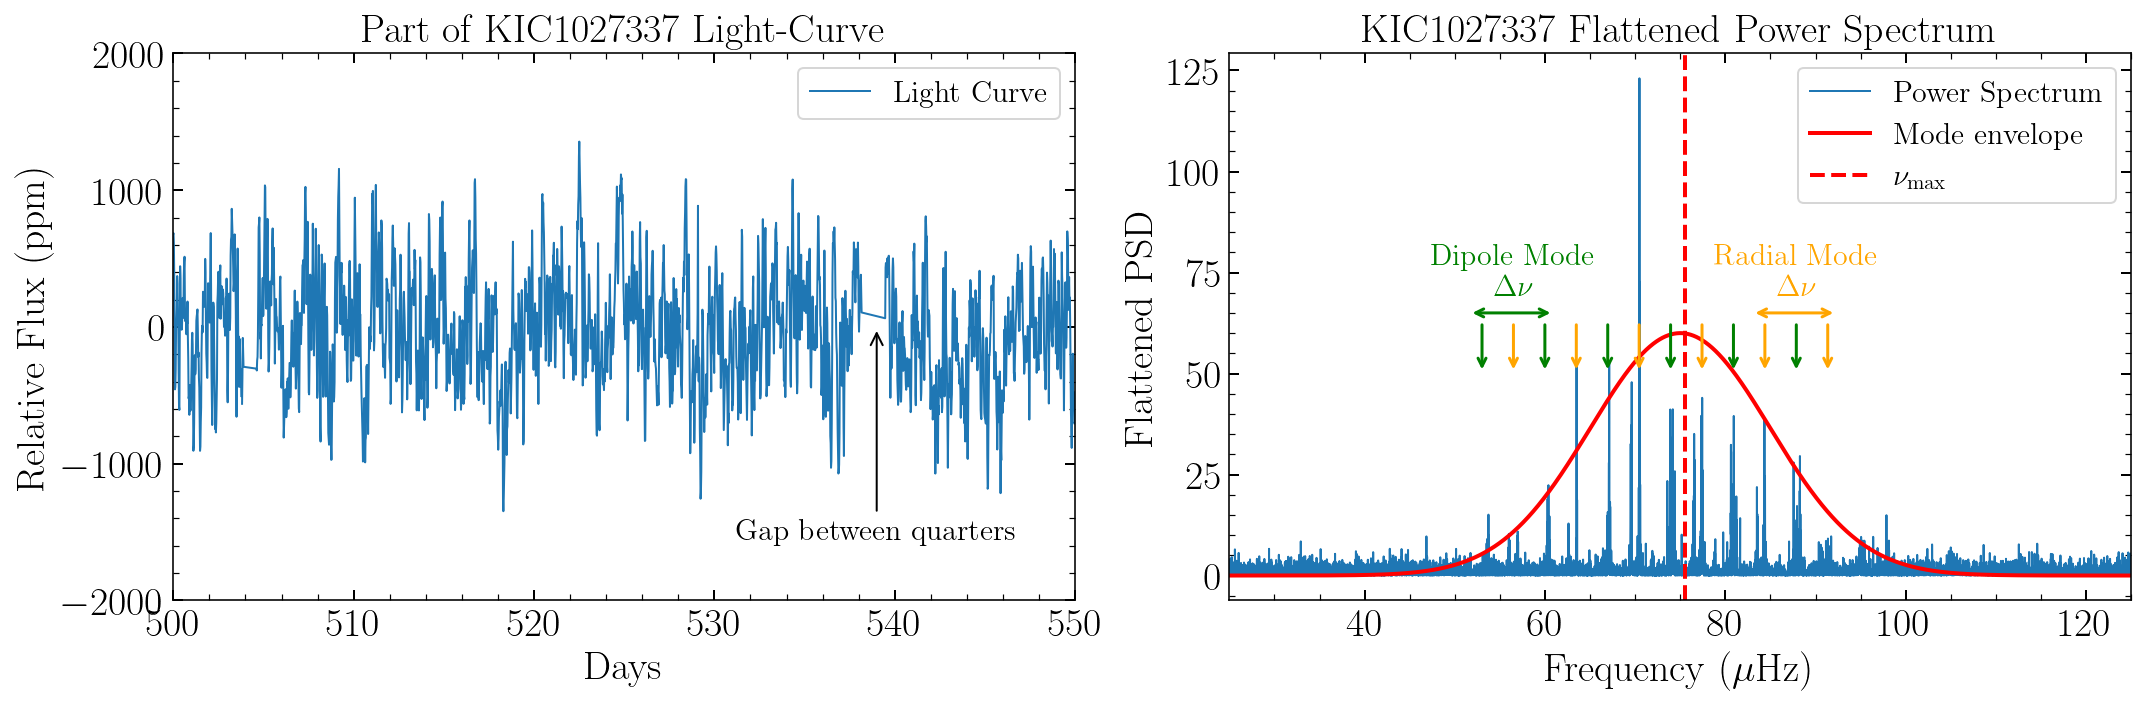

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.set_title("Part of KIC1027337 Light-Curve")
ax1.plot(lc.time.value, lc.flux.value-10**6, label="Light Curve")
ax1.set_xlabel("Days")
ax1.set_ylabel("Relative Flux (ppm)")
ax1.set_xlim(500, 550)
ax1.set_ylim(-2000, 2000)
ax1.legend()
ax1.annotate(
    "Gap between quarters",
    xy=(539, 0.),
    xytext=(539, -1500),
    color="black",
    fontsize=15,
    va="center",
    ha="center",
    arrowprops=dict(arrowstyle="->", color="black", linewidth=1),
)

ax2.set_title("KIC1027337 Flattened Power Spectrum")
ax2.plot(snr.frequency, snr.power, label="Power Spectrum")
ax2.plot(
    snr.frequency.value,
    60 * np.exp(-((snr.frequency.value - 75) ** 2) / (2 * 10 ** 2)),
    lw=2,
    color="red",
    label="Mode envelope",
)

for i in range(6):
    ax2.annotate(
        " ",
        xy=(56.5 + i * 6.97, 50),
        xytext=(56.5 + i * 6.97, 65),
        arrowprops=dict(arrowstyle="->", color="orange", linewidth=1.5),
    )

ax2.annotate(
    " ",
    xy=(87.865 - 5.0, 65),
    xytext=(87.865 + 5.0, 65),
    arrowprops=dict(arrowstyle="<->", color="orange", linewidth=1.5),
    va="center",
    ha="center",
)

ax2.annotate(
    "Radial Mode \n" + r"$\Delta \nu$",
    xy=(87.865, 75),
    xytext=(87.865, 75),
    color="orange",
    fontsize=15,
    va="center",
    ha="center",
)


for i in range(6):
    ax2.annotate(
        " ",
        xy=(56.5 + i * 6.97 - 6.97 / 2, 50),
        xytext=(56.5 + i * 6.97 - 6.97 / 2, 65),
        arrowprops=dict(arrowstyle="->", color="green", linewidth=1.5),
    )

ax2.annotate(
    " ",
    xy=(56.5 - 5.0, 65),
    xytext=(56.5 + 5.0, 65),
    arrowprops=dict(arrowstyle="<->", color="green", linewidth=1.5),
    va="center",
    ha="center",
)

ax2.annotate(
    "Dipole Mode \n" + r"$\Delta \nu$",
    xy=(56.5, 75),
    xytext=(56.5, 75),
    color="green",
    fontsize=15,
    va="center",
    ha="center",
)

ax2.axvline(75.5, lw=2, ls="--", c="r", label=r"$\nu_\mathrm{max}$")
ax2.set_xlabel("Frequency ($\mu \mathrm{Hz}$)")
ax2.set_ylabel("Flattened PSD")
ax2.set_xlim(25, 125)
ax2.legend()

fig.tight_layout()
fig.savefig("seismology.pdf")

## TESS Kepler

In [ ]:
import astropy.units as u
import gaia_tools.xmatch
import numpy as np
from astroNN.apogee import allstar
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table, vstack
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
from tqdm.notebook import tqdm

allstar_f = fits.getdata(allstar(dr=14))
allstar_f17 = fits.getdata(allstar(dr=17))
allstar_f17 = allstar_f17[1:]
# get Gaia eDR3 Source ID from APOGEE DR17
idx_1, idx_2, sep = gaia_tools.xmatch.xmatch(
    allstar_f, allstar_f17, colRA2="ra", colDec2="dec", epoch2=2000.0
)
source_id = np.ones(allstar_f["ra"].shape[0], dtype=np.int64) * -1
source_id[idx_1] = allstar_f17["GAIAEDR3_SOURCE_ID"][idx_2]

# load catalog
_apokasc2 = Table(Table.read("APOKASC2_Table5.txt", format="ascii"), masked=True)

# mask bad values to -9999.
for item in _apokasc2.colnames[:-3]:
    mask = (
        np.array([x == "..." for x in _apokasc2[item]])
        | np.array(["REJECT" in str(x) for x in _apokasc2[item]])
        | np.array(["(S)" in str(x) for x in _apokasc2[item]])
        | np.array(["Bad Teff" in str(x) for x in _apokasc2[item]])
        | np.array(["AMB" in str(x) for x in _apokasc2[item]])
    )
    _apokasc2[item].mask = mask
    _apokasc2[item].fill_value = -9999.0

total_num = _apokasc2["2MASS"].size
apogeeidx = np.zeros(total_num, dtype=int)

# cross match to APOGEE by APOGEE_ID
for i in range(total_num):
    apogeeidx[i] = np.where(allstar_f["APOGEE_ID"] == _apokasc2["2MASS"].filled()[i])[
        0
    ][0]

cats = []

ra = allstar_f["ra"][apogeeidx]
dec = allstar_f["dec"][apogeeidx]

# query 100 stars each time to TESS, should be 6676 in total
# https://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=IV/38/tic
num_100 = 66
for i in tqdm(range(num_100)):
    cats.append(
        Vizier.query_region(
            SkyCoord(
                ra=ra[100 * i : 100 * i + 100] * u.deg,
                dec=dec[100 * i : 100 * i + 100] * u.deg,
            ),
            catalog="IV/38",
            radius=10 * u.arcsecond,
        )
    )

# do the remaining
cats.append(
    Vizier.query_region(
        SkyCoord(ra=ra[num_100 * 100 :] * u.deg, dec=dec[num_100 * 100 :] * u.deg),
        catalog="IV/38",
        radius=10 * u.arcsecond,
    )
)

cat = vstack([cat[0] for cat in cats])

tic = np.ones(ra.size, dtype=np.int64) * -1

for idx, source_id in enumerate(source_id[apogeeidx]):
    cat_idx = np.where(cat["GAIA"] == source_id)
    if cat_idx[0].size > 1:
        cat_idx = cat_idx[0][0]
    elif cat_idx[0].size == 1:
        pass
    else:
        # probably due to cross-matching error, explicitly search KIC to source_id
        flag = 0
        result_table = Simbad.query_objectids(f"KIC{_apokasc2['KIC'][idx]}")
        if result_table is not None:
            for result in result_table:
                if "Gaia EDR3" in str(result) and flag == 0:
                    flag = 1
                    source_id = np.int64(str(result)[-19:])
                    print(f"Gaia EDR3 {source_id} has no correct match in TESS")
                    cat_idx = np.where(cat["GAIA"] == source_id)
                    if cat_idx[0].size > 1:
                        cat_idx = cat_idx[0][0]
        else:
            continue
        if flag == 0:
            continue
    tic[idx] = cat["TIC"][cat_idx]

In [13]:
np.savetxt("TIC.csv", tic)

In [1]:
import astropy.units as u
import h5py
import lightkurve
from astroNN.gaia import fakemag_to_mag
from astroNN.shared.matplotlib import pylab_style
from astropy.convolution import Gaussian1DKernel, convolve
from scipy.stats import binned_statistic
from tqdm import tqdm

pylab_style(paper=True)

f = h5py.File("APOKASC2.h5", "r")
k_mag = fakemag_to_mag(f["fakemag"][()], f["parallax"][()] * u.mas)

# bright stars lower RC
good_idx = (
    (f["LOGG"][()] > 2.5) & (f["ES"][()] == b"RGB") & (k_mag < 9.0) & (k_mag != -9999.0)
)
TICs = f["TIC"][good_idx]
Numaxs = f["Numax"][good_idx]

# for tic, numax in zip(tqdm(TICs), Numaxs):
#     search = lightkurve.search_lightcurve(f"TIC {tic}", author="QLP")
#     if len(search) == 0:
#         continue
#     else:
#         lc = search.download_all().stitch()
#         pg = lc.to_periodogram(
#             normalization="psd", minimum_frequency=1, maximum_frequency=300
#         )
#         binned_pg, xe, bunnum = binned_statistic(
#             np.log10(pg.frequency.value),
#             pg.power.value,
#             range=(np.log10(1), np.log10(300)),
#             bins=1000,
#             statistic=np.nanmean,
#         )
#         pg_smooth = convolve(binned_pg, Gaussian1DKernel(stddev=10))

#         fig = plt.figure()
#         plt.plot(pg.frequency, pg.power)
#         plt.plot(
#             10 ** ((xe[1:] + xe[:-1]) / 2), pg_smooth, lw=5.0, label="Smoothed Spectrum"
#         )
#         plt.axvline(numax, c="k", ls="--")
#         plt.loglog()
#         plt.title(f"{numax}")
#         plt.savefig(f"tess_fig/{tic}.png")
#         plt.close("all")

C:\Users\Henry\AppData\Local\Temp/ipykernel_24464/4196355698.py:153: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


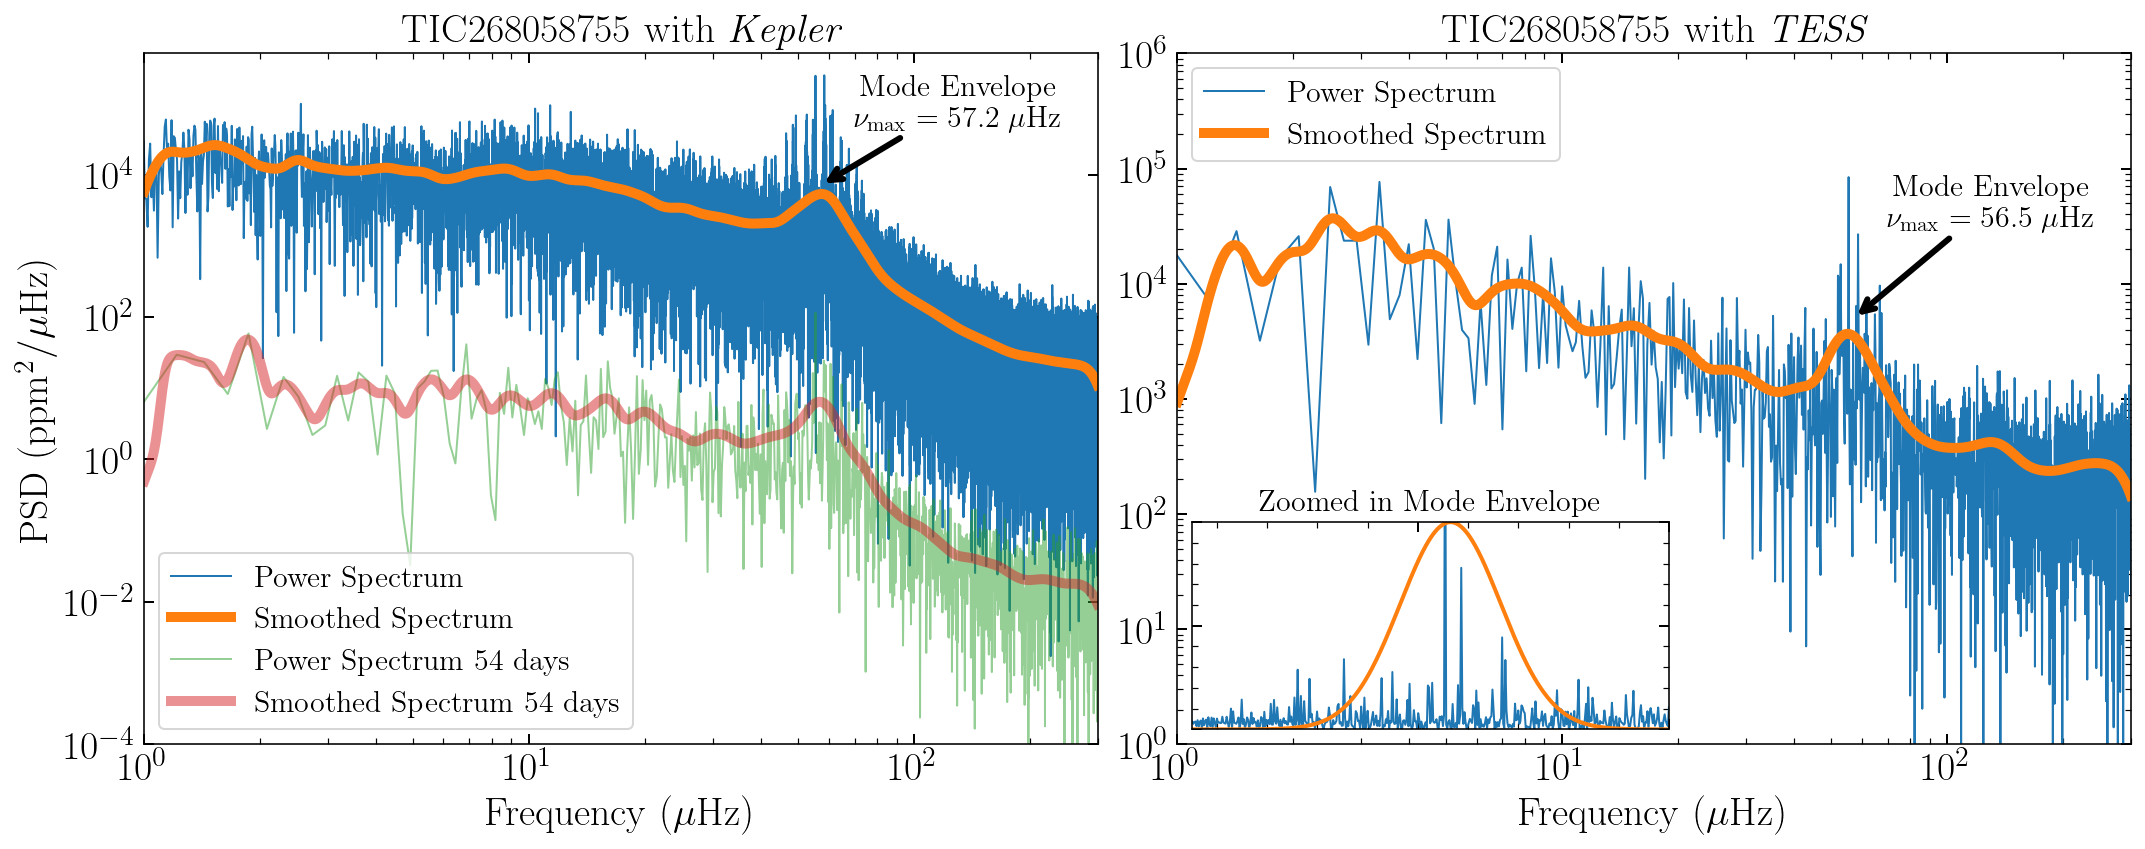

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

tic = 268058755
kic = f["KIC"][np.where(f["TIC"][()] == tic)[0][0]]
numax = f["Numax"][np.where(f["TIC"][()] == tic)[0][0]]

f_lc = h5py.File("APOKASC2_lightcurves.h5", "r")
lc = np.array(f_lc[f"{kic}"])
lc_k54 = lightkurve.LightCurve(
    {
        "flux": lc[0][(lc[1] > 400) & (lc[1] < 454)],
        "time": lc[1][(lc[1] > 400) & (lc[1] < 454)],
    }
)
lc = lightkurve.LightCurve({"flux": lc[0], "time": lc[1]})
pg = lc.normalize(unit="ppm").to_periodogram(
    normalization="psd", minimum_frequency=1, maximum_frequency=300
)
snr = pg.flatten()

pg_k54 = lc_k54.normalize(unit="ppm").to_periodogram(
    normalization="psd", minimum_frequency=1, maximum_frequency=300
)
snr_k54 = pg_k54.flatten()

search = lightkurve.search_lightcurve(f"TIC {tic}", author="QLP")
lc_tess = search.download_all().stitch()
pg_tess = lc_tess.normalize(unit="ppm").to_periodogram(
    normalization="psd", minimum_frequency=1, maximum_frequency=300
)

snr_tess = pg_tess.flatten()

binned_pg, xe, bunnum = binned_statistic(
    np.log10(pg.frequency.value),
    pg.power.value,
    range=(np.log10(1), np.log10(300)),
    bins=1000,
    statistic=np.nanmean,
)
binned_pg_k54, xe, bunnum = binned_statistic(
    np.log10(pg_k54.frequency.value),
    pg_k54.power.value,
    range=(np.log10(1), np.log10(300)),
    bins=1000,
    statistic=np.nanmean,
)
binned_pg_tess, xe, bunnum = binned_statistic(
    np.log10(pg_tess.frequency.value),
    pg_tess.power.value,
    range=(np.log10(1), np.log10(300)),
    bins=1000,
    statistic=np.nanmean,
)

pg_smooth = convolve(binned_pg, Gaussian1DKernel(stddev=10))
pg_k54_smooth = convolve(binned_pg_k54, Gaussian1DKernel(stddev=10))
pg_tess_smooth = convolve(binned_pg_tess, Gaussian1DKernel(stddev=15))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(pg.frequency, pg.power, label="Power Spectrum")
ax1.plot(
    10 ** ((xe[1:] + xe[:-1]) / 2), pg_smooth, lw=5.0, c="C1", label="Smoothed Spectrum"
)
ax1.plot(
    pg_k54.frequency,
    pg_k54.power / 1000,
    c="C2",
    alpha=0.5,
    label="Power Spectrum 54 days",
)
ax1.plot(
    10 ** ((xe[1:] + xe[:-1]) / 2),
    pg_k54_smooth / 1000,
    lw=5.0,
    c="C3",
    alpha=0.5,
    label="Smoothed Spectrum 54 days",
)
ax1.set_xlim(1, 300)
ax1.set_ylim(10 ** -4, 5 * 10 ** 5)
ax1.loglog()
ax1.set_title(f"TIC{tic} with $\emph{{Kepler}}$")
ax1.set_xlabel("Frequency ($\mu \mathrm{Hz}$)")
ax1.set_ylabel("PSD ($\mathrm{ppm}^2 / \mu \mathrm{Hz}$)")
ax1.legend(loc="best")
ax1.annotate(
    "Mode Envelope \n" + r"$\nu_\mathrm{max}=57.2\ \mu\mathrm{Hz}$",
    xy=(numax, 7 * 10 ** 3),
    xytext=(130.0, 1 * 10 ** 5),
    color="black",
    fontsize=15,
    va="center",
    ha="center",
    arrowprops=dict(arrowstyle="->", color="black", linewidth=3),
)

ax2.plot(pg_tess.frequency, pg_tess.power, label="Power Spectrum")
ax2.plot(
    10 ** ((xe[1:] + xe[:-1]) / 2),
    pg_tess_smooth,
    lw=5.0,
    c="C1",
    label="Smoothed Spectrum",
)
# ax2.plot(
#     10 ** ((xe[1:] + xe[:-1]) / 2),
#     pg_k54_smooth / 10,
#     lw=5.0,
#     c="C3",
#     alpha=0.5,
#     label="$\emph{{Kepler}}$ Smoothed Spectrum 54 days",
# )

ax2.set_xlim(1, 300)
ax2.set_ylim(10 ** -0, 1 * 10 ** 6)
ax2.loglog()
ax2.set_title(f"TIC{tic} with $\emph{{TESS}}$")
ax2.set_xlabel("Frequency ($\mu \mathrm{Hz}$)")
ax2.legend(loc="upper left")
ax2.annotate(
    "Mode Envelope \n" + r"$\nu_\mathrm{max}=56.5\ \mu\mathrm{Hz}$",
    xy=(numax, 5 * 10 ** 3),
    xytext=(130.0, 5 * 10 ** 4),
    color="black",
    fontsize=15,
    va="center",
    ha="center",
    arrowprops=dict(arrowstyle="->", color="black", linewidth=3),
)

ax3 = inset_axes(
    ax2,
    width="50%",
    height="30%",
    loc="lower left",  # width = 30% of parent_bbox  # height : 1 inch
)
ax3.plot(snr_tess.frequency, snr_tess.power, label="Flattened Power Spectrum")
ax3.set_xlim(5, 100)
ax3.set_ylim(0, 20)
ax3.set_yticklabels([])
ax3.set_xticklabels([])
ax3.plot(
    snr_tess.frequency.value,
    20 * np.exp(-((snr_tess.frequency.value - 56.5) ** 2) / (2 * 10 ** 2)),
    lw=2,
    color="C1",
    label="Mode envelope",
)

ax3.set_title("Zoomed in Mode Envelope", fontsize=15)

fig.tight_layout()
fig.savefig("kepler_tess_comparison.pdf")

In [18]:
s = pg.to_seismology()
s.estimate_numax()
s.estimate_deltanu()

C:\Users\Henry\miniconda3\lib\site-packages\lightkurve\seismology\core.py:75: LightkurveWarning: Seismology received a periodogram which does not appear to have been background-corrected. Please consider calling `periodogram.flatten()` prior to extracting seismological parameters.


deltanu: 2.28 uHz (method: ACF2D)

In [6]:
f["Numax"][np.where(f["TIC"][()] == tic)[0][0]], f["Deltanu"][
    np.where(f["TIC"][()] == tic)[0][0]
], f["K"][np.where(f["TIC"][()] == tic)[0][0]]

(57.189, 6.068, 7.354)

# APOGEE DR17

Text(0, 0.5, 'NN Age (Gyr)')

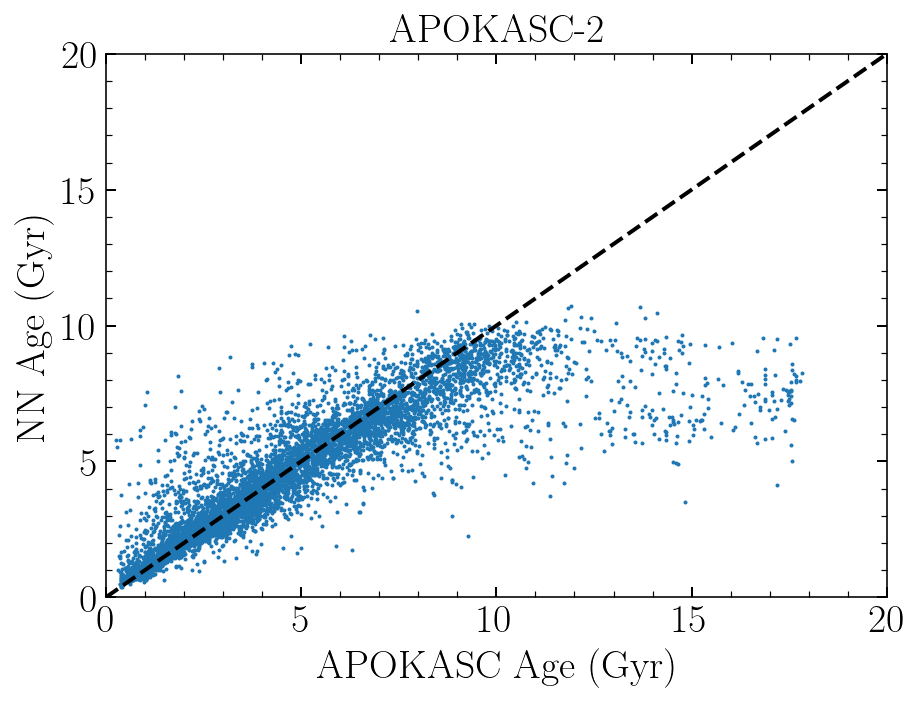

In [10]:
import h5py
import numpy as np
import astropy.units as u
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
from astroNN.apogee import allstar, apogee_astronn
from tqdm.notebook import tqdm
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
from astroNN.datasets import xmatch
from astroNN.shared.matplotlib import pylab_style

pylab_style(paper=True)


allstar_f = fits.getdata(allstar(dr=17))
allstar_astroNN_f = fits.getdata(apogee_astronn(dr=17))
ra = allstar_f["ra"]
dec = allstar_f["dec"]

ra[0] = 0
dec[0] = 0

# load catalogs
apokasc3 = fits.getdata("../APOKASC_cat_v6.6.1.fits.zip")
good_ages = ((apokasc3["APOKASC2_AGE"] != -9999.) & (apokasc3["APOKASC2_AGE_MERR"]/apokasc3["APOKASC2_AGE"] < 0.5))
apokasc3 = apokasc3[good_ages]

f_age_low_M = fits.getdata("../kepler_low_metallicity_with_samples.fits")

idx_1, idx_2, sep = xmatch(apokasc3["RA"], apokasc3["DEC"], ra, dec)
idx_3, idx_4, sep = xmatch(f_age_low_M["RA"], f_age_low_M["DEC"], ra, dec)

idx_combined, unique_indices = np.unique(np.concatenate([idx_4, idx_2]), return_index=True)

allstar_f = allstar_f[idx_combined]
allstar_astroNN_f = allstar_astroNN_f[idx_combined]

all_age = np.concatenate([f_age_low_M["Age_med "]/1e9, apokasc3['APOKASC2_AGE']])[unique_indices]
all_age_err = np.concatenate([f_age_low_M["Age_Sd "]/1e9, apokasc3['APOKASC2_AGE_MERR']])[unique_indices]
all_mass = np.concatenate([f_age_low_M["Mass_med "], apokasc3['APOKASC2_MASS']])[unique_indices]
all_mass_err = np.concatenate([f_age_low_M["Mass_Sd "], apokasc3['APOKASC2_MASS_RANERR']])[unique_indices]

agemass = np.stack([all_age, all_mass]).T
agemass_err = np.stack([all_age_err, all_mass_err]).T

plt.figure(figsize=(7,5))
plt.scatter(all_age, allstar_astroNN_f["age"], s=1)
plt.plot([0, 20], [0, 20], lw=2, c="k", ls="--")
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.title("APOKASC-2")
plt.xlabel("APOKASC-2 Age (Gyr)")
plt.ylabel("NN Age (Gyr)")

In [14]:
from astropy.stats import mad_std

np.nanmedian(np.abs((all_age- allstar_astroNN_f["age"]) / all_age))

0.11862209511408095

# RC vs RGB comparison

In [12]:
import h5py
import pandas as pd
from astroNN.shared.matplotlib import pylab_style

pylab_style(paper=True)

pg = lc.to_periodogram(normalization="psd", minimum_frequency=1, maximum_frequency=300)

f = h5py.File("APOKASC2.h5", "r")
rgb = np.array(f["ES"]).astype(str) == "RGB"
rc = np.array(f["ES"]).astype(str) == "RC"

rc_idx = f["KIC"][rc][np.argmin(np.abs(f["Numax"][rc] - 50))]
rgb_idx = f["KIC"][rgb][np.argmin(np.abs(f["Numax"][rgb] - 50))]

f_lc = h5py.File("APOKASC2_lightcurves.h5", "r")
lc_rc = np.array(f_lc[str(rc_idx)])
lc_rc = lightkurve.LightCurve({"flux": lc_rc[0], "time": lc_rc[1]})
lc_rgb = np.array(f_lc[str(rgb_idx)])
lc_rgb = lightkurve.LightCurve({"flux": lc_rgb[0], "time": lc_rgb[1]})

pg_rc = lc_rc.to_periodogram(
    normalization="psd", minimum_frequency=1, maximum_frequency=300
)
pg_rgb = lc_rgb.to_periodogram(
    normalization="psd", minimum_frequency=1, maximum_frequency=300
)

snr_rc = pg_rc.flatten()
snr_rgb = pg_rgb.flatten()

(1.0, 100.0)

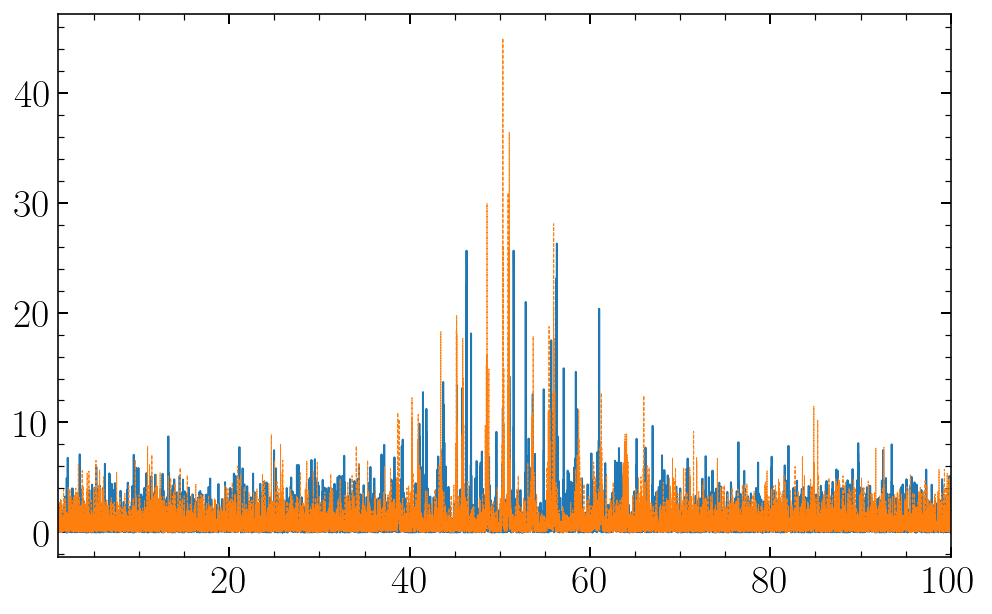

In [15]:
plt.plot(snr_rc.frequency, snr_rc.power, label="Power Spectrum")
plt.plot(snr_rgb.frequency, snr_rgb.power, label="Power Spectrum", ls="--", lw=0.5)
plt.xlim(1, 100)

In [18]:
seis_rgb = snr_rgb.to_seismology()
seis_rc = snr_rc.to_seismology()

<AxesSubplot:title={'center':'Echelle diagram for None'}, xlabel='Frequency mod. 5.13 uHz', ylabel='Frequency [$\\mathrm{\\mu Hz}$]'>

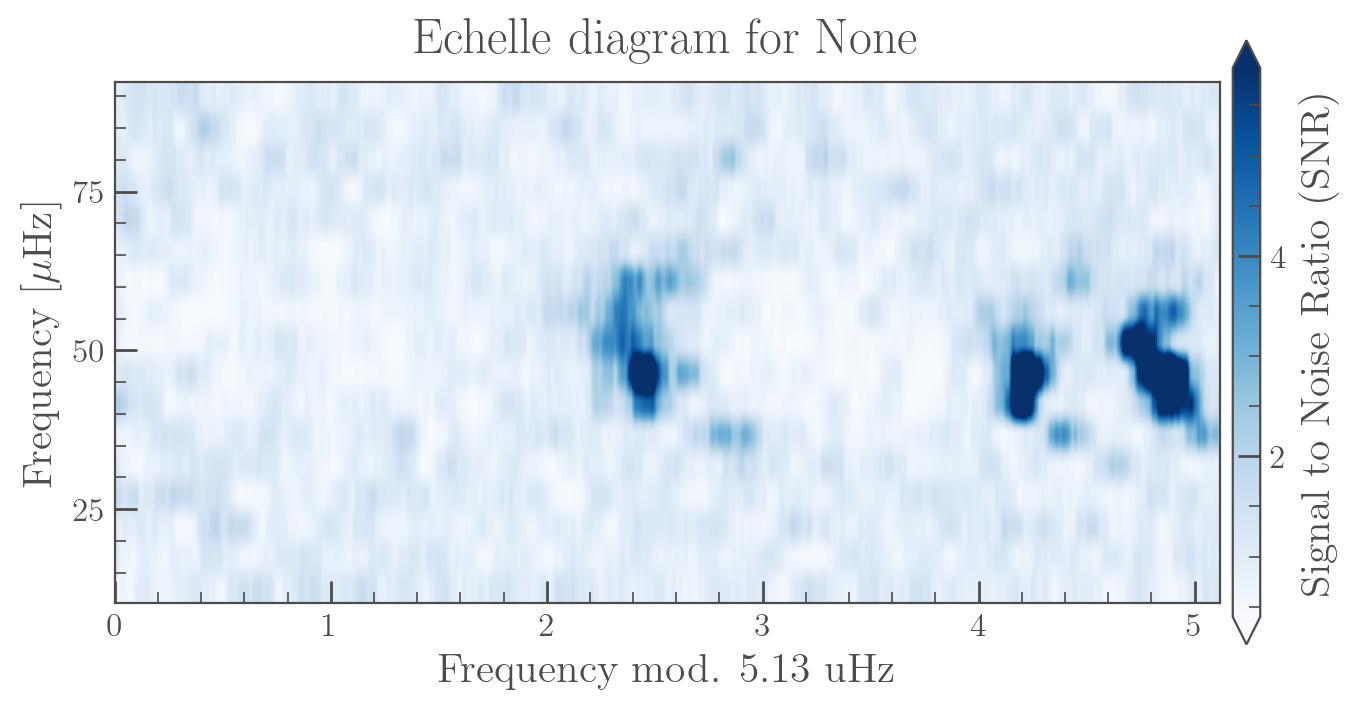

In [21]:
seis_rgb.estimate_numax()
seis_rgb.estimate_deltanu()
seis_rgb.plot_echelle()

<AxesSubplot:title={'center':'Echelle diagram for None'}, xlabel='Frequency mod. 4.76 uHz', ylabel='Frequency [$\\mathrm{\\mu Hz}$]'>

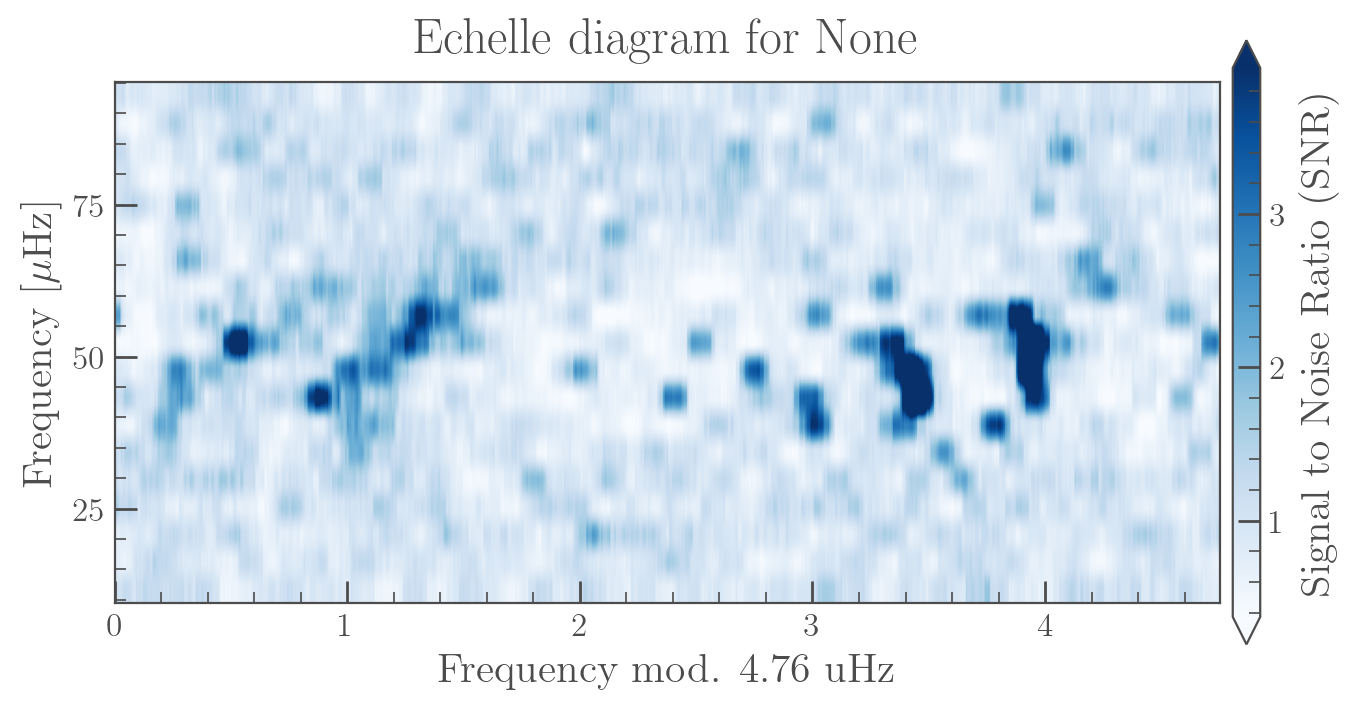

In [22]:
seis_rc.estimate_numax()
seis_rc.estimate_deltanu()
seis_rc.plot_echelle()